# ESP Optimal Frequency Solver using Scipy
**Author:** Ade Anggi Naluriawan Santoso | **Project:** Anomaly Detection and Reliability

### Objective
Find the Variable Speed Drive (VSD) frequency ($f$) that **maximizes Oil Rate** subject to a **Motor Temperature constraint**.

### Mathematical Model
1.  **Objective Function (Maximize Flow):**
    We assume the pump follows Affinity Laws closely near the operating point.
    $$Q_{new} = Q_{ref} \times \left( \frac{f_{new}}{f_{ref}} \right)$$

2.  **Constraint Function (Temperature Limit):**
    We model Motor Temperature ($T$) as increasing quadratically with frequency (representing increased friction and electrical losses).
    $$T_{new} = T_{ref} \times \left( \frac{f_{new}}{f_{ref}} \right)^2$$
    $$\text{Constraint: } T_{limit} - T_{new} \ge 0$$

### Libraries
We will use `scipy.optimize.minimize` with the **SLSQP** (Sequential Least Squares Programming) method, which handles inequality constraints well.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import seaborn as sns

# Configuration for plots
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

### 1. Load Data
We load a snapshot of current operating conditions for several wells.

In [2]:
# Load the dataset
df = pd.read_csv('esp_operational_data.csv')

# Display the data
print("Current ESP Operational Parameters:")
display(df)

Current ESP Operational Parameters:


,Well_ID,Current_Freq_Hz,Current_Oil_Rate_BPD,Current_Motor_Temp_C,Max_Temp_Limit_C,Res_Pressure_PSI,PI_BPD_PSI
0,Well-001,45.0,850.0,110.0,135.0,2500,1.2
1,Well-002,50.0,1200.0,125.0,140.0,2800,1.5
2,Well-003,35.0,500.0,90.0,130.0,2100,0.8
3,Well-004,55.0,1600.0,138.0,140.0,3000,1.8
4,Well-005,40.0,750.0,100.0,135.0,2400,1.1


### 2. Define Physics Models
Here we define the functions that predict Flow and Temperature based on a new input Frequency. These functions serve as our "Simulator" during the optimization loop.

In [3]:
def predict_rate(freq_new, freq_ref, rate_ref):
    """
    Predicts oil rate using Affinity Laws: Q2 = Q1 * (N2/N1)
    """
    if freq_new < 0: return 0 # Physical constraint
    return rate_ref * (freq_new / freq_ref)

def predict_temp(freq_new, freq_ref, temp_ref):
    """
    Predicts motor temp assuming quadratic relationship with speed: T2 = T1 * (N2/N1)^2
    (Simplified thermal model for demonstration)
    """
    return temp_ref * (freq_new / freq_ref)**2

### 3. Optimization Engine
We define the `optimize_well` function. This function sets up the objective and constraints for `scipy`.

* **Objective:** Minimize ` -1 * rate` (effectively maximizing rate).
* **Constraint:** `limit - actual_temp` must be non-negative.
* **Bounds:** Frequency is bounded between 30Hz (min stable) and 70Hz (mechanical limit).

In [4]:
def optimize_well(row):
    # Reference values from current snapshot
    f_ref = row['Current_Freq_Hz']
    q_ref = row['Current_Oil_Rate_BPD']
    t_ref = row['Current_Motor_Temp_C']
    t_limit = row['Max_Temp_Limit_C']
    
    # 1. Objective Function: Maximize Rate -> Minimize Negative Rate
    def objective(f):
        return -1 * predict_rate(f[0], f_ref, q_ref)
    
    # 2. Constraint: Temp <= Limit -> (Limit - Temp) >= 0
    def constraint_temp(f):
        t_pred = predict_temp(f[0], f_ref, t_ref)
        return t_limit - t_pred
    
    # Define constraints dictionary for SLSQP
    cons = ({'type': 'ineq', 'fun': constraint_temp})
    
    # Define Bounds (Operating limits of the VSD, e.g., 30Hz to 65Hz)
    bounds = [(30.0, 65.0)]
    
    # Initial Guess (Current Frequency)
    x0 = [f_ref]
    
    # Run Optimization
    solution = minimize(objective, x0, method='SLSQP', bounds=bounds, constraints=cons)
    
    return pd.Series({
        'Optimal_Freq_Hz': np.round(solution.x[0], 2),
        'Optimized_Rate_BPD': np.round(predict_rate(solution.x[0], f_ref, q_ref), 2),
        'Predicted_Temp_C': np.round(predict_temp(solution.x[0], f_ref, t_ref), 2),
        'Success': solution.success,
        'Message': solution.message
    })

# Apply optimization to every well in the dataframe
results = df.apply(optimize_well, axis=1)

# Concatenate results back to original dataframe
final_df = pd.concat([df, results], axis=1)

display(final_df[['Well_ID', 'Current_Freq_Hz', 'Optimal_Freq_Hz', 
                  'Current_Oil_Rate_BPD', 'Optimized_Rate_BPD', 
                  'Current_Motor_Temp_C', 'Predicted_Temp_C', 'Max_Temp_Limit_C']])

,Well_ID,Current_Freq_Hz,Optimal_Freq_Hz,Current_Oil_Rate_BPD,Optimized_Rate_BPD,Current_Motor_Temp_C,Predicted_Temp_C,Max_Temp_Limit_C
0,Well-001,45.0,49.85,850.0,941.65,110.0,135.0,135.0
1,Well-002,50.0,52.92,1200.0,1269.96,125.0,140.0,140.0
2,Well-003,35.0,42.06,500.0,600.93,90.0,130.0,130.0
3,Well-004,55.0,55.40,1600.0,1611.55,138.0,140.0,140.0
4,Well-005,40.0,46.48,750.0,871.42,100.0,135.0,135.0


### 4. Visualization: Optimization Surface
Let's visualize the "Solution Space" for **Well-002**. We will plot the Oil Rate curve and the Temperature curve against frequency to visually verify why the solver chose the specific frequency.

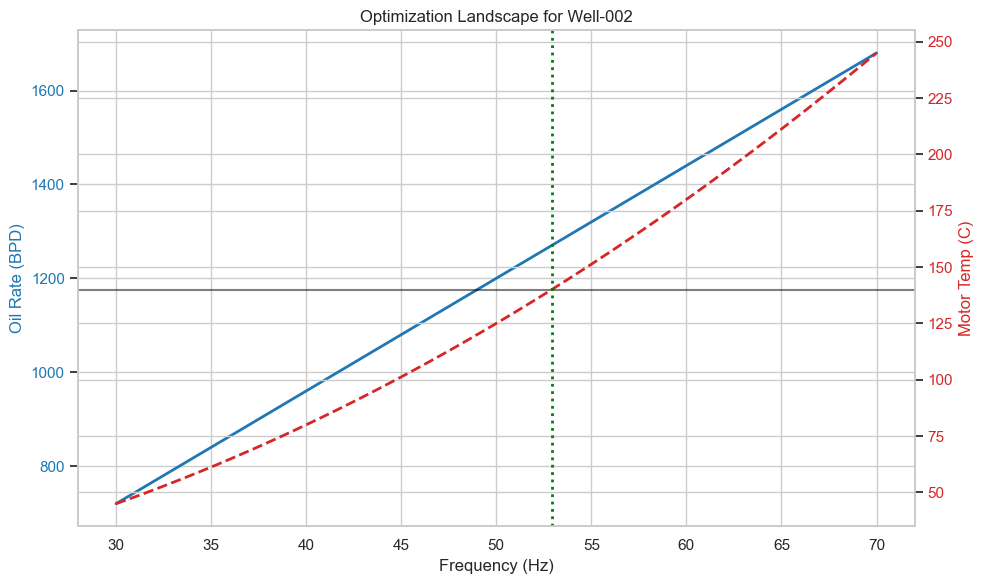

In [5]:
# Select Well-002
well = df.iloc[1] 
f_range = np.linspace(30, 70, 100)

# Calculate physical properties across the frequency range
rates = [predict_rate(f, well['Current_Freq_Hz'], well['Current_Oil_Rate_BPD']) for f in f_range]
temps = [predict_temp(f, well['Current_Freq_Hz'], well['Current_Motor_Temp_C']) for f in f_range]

fig, ax1 = plt.subplots()

# Plot Oil Rate (Blue)
color = 'tab:blue'
ax1.set_xlabel('Frequency (Hz)')
ax1.set_ylabel('Oil Rate (BPD)', color=color)
ax1.plot(f_range, rates, color=color, linewidth=2, label='Oil Rate')
ax1.tick_params(axis='y', labelcolor=color)

# Plot Temperature (Red)
ax2 = ax1.twinx()  
color = 'tab:red'
ax2.set_ylabel('Motor Temp (C)', color=color)
ax2.plot(f_range, temps, color=color, linestyle='--', linewidth=2, label='Motor Temp')
ax2.tick_params(axis='y', labelcolor=color)

# Add Limit Line
plt.axhline(y=well['Max_Temp_Limit_C'], color='black', linestyle='-', alpha=0.5, label='Temp Limit')

# Add Optimal Point Marker
opt_freq = final_df.iloc[1]['Optimal_Freq_Hz']
plt.axvline(x=opt_freq, color='green', linestyle=':', linewidth=2, label=f'Optimal Freq: {opt_freq} Hz')

plt.title(f"Optimization Landscape for {well['Well_ID']}")
fig.tight_layout()
plt.show()